In [9]:
%matplotlib notebook
import mne
import matplotlib.pyplot as plt

fname = "./oddball-epo.fif"

event_ids = {"standard/stimulus": 200, "target/stimulus": 100}

# Read in epochs

In [10]:
epochs = mne.read_epochs(fname)

## MVPA/decoding

Can we predict trial type from EEG activity?

In [11]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [12]:
epochs

<EpochsFIF  |   218 events (all good), -0.2 - 0.5 sec, baseline [-0.2, 0], ~7.7 MB, data loaded,
 'standard/stimulus': 109
 'target/stimulus': 109>

In [13]:
epochs.pick_types(eeg=True)
X = epochs.get_data()  # features
y = epochs.events[:, -1] == event_ids["target/stimulus"]  # targets
X.shape, y.shape

((218, 63, 71), (218,))

X has the wrong shape - `samples`, `channels`, `times`, should be `samples`, `features`.

We can use `mne.decoding.Vectorizer` to correctly shape the data. It fits right into a scikit-learn pipeline.

In [14]:
from mne.decoding import Vectorizer
clf = make_pipeline(Vectorizer(), StandardScaler(), LinearSVC(class_weight="balanced"))

In [15]:
cross_val_score(clf, X, y)  # accuracy

array([0.71621622, 0.86111111, 0.69444444])

At which time points in the trial is there information about trial category?

We need two more tools for this: one to train and score at each time point, and one to handle the cross-validated scoring for the former.

In [16]:
from mne.decoding import SlidingEstimator, cross_val_multiscore
sl = SlidingEstimator(clf)

In [17]:
scores_time_decoding = cross_val_multiscore(sl, X, y)

In [18]:
scores_time_decoding.shape

(3, 71)

<IPython.core.display.Javascript object>


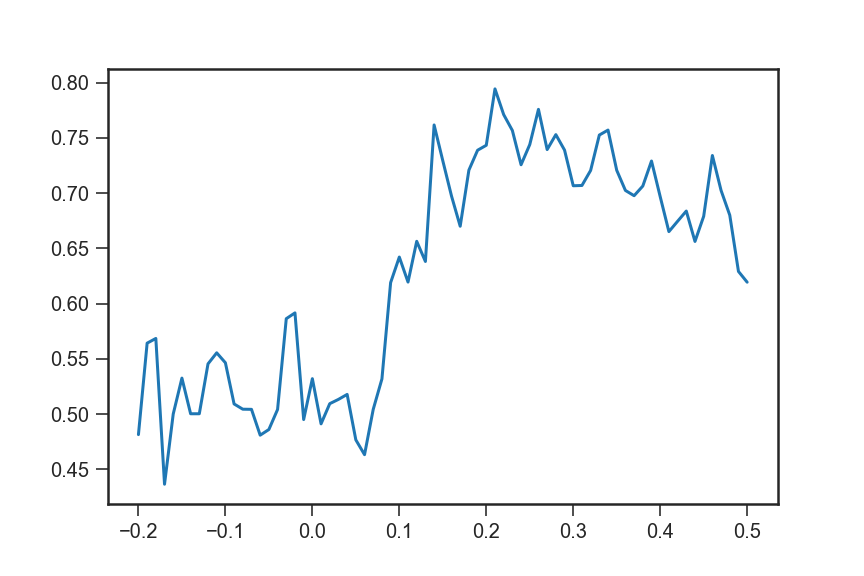

In [19]:
fig, ax = plt.subplots()
ax.plot(epochs.times, scores_time_decoding.mean(0))
plt.show()

But is the same thing happening at each time point? We can investigate that with generalization across time decoding.

In [20]:
from mne.decoding import GeneralizingEstimator
gen = GeneralizingEstimator(clf)
scores_gat = cross_val_multiscore(gen, X, y)

In [21]:
scores_gat.shape

(3, 71, 71)

<IPython.core.display.Javascript object>


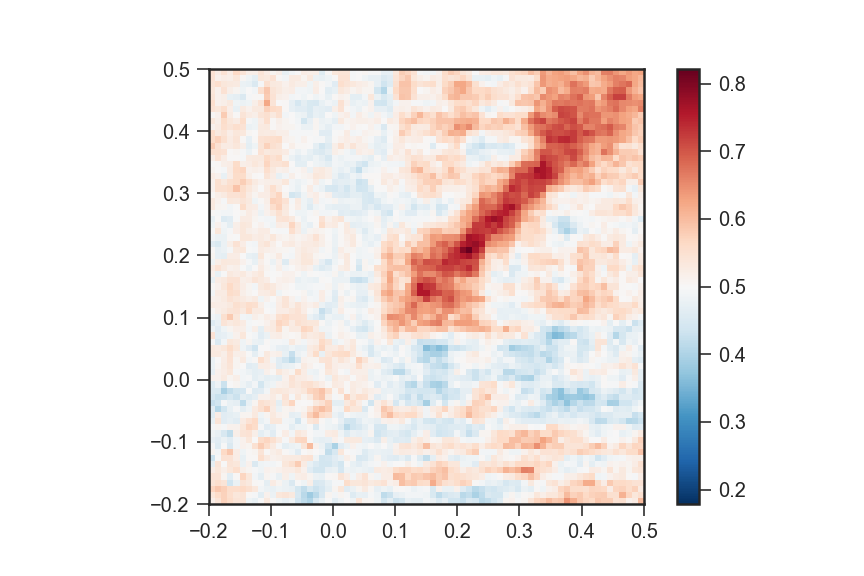

In [22]:
import numpy as np
data = scores_gat.mean(0)
vmax = np.abs(data).max()
tmin, tmax = epochs.times[[0, -1]]

fig, ax = plt.subplots()
im = ax.imshow(
    data,
    origin="lower", cmap="RdBu_r",
    extent=(tmin, tmax, tmin, tmax),
    vmax=vmax, vmin=1-vmax);

plt.colorbar(im)